In [1]:
import os, glob, pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, RocCurveDisplay

import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [11]:
def loads_npy_with_y(base_path, ids, y_value):
    loaded_npa_list = []
    for id in ids:
        file_path = glob.glob(f'{base_path}/{id}*.npy')[0]
        if not isinstance(file_path, str):
            raise Exception(f"could'n find id({id}) file ")
        npa = np.load(file_path)
        n = npa.shape[0]
        y = np.array([y_value] * n, dtype=npa.dtype)
        npa = np.concatenate([npa,y.reshape(-1,1)], axis=1)
        loaded_npa_list.append(npa)
    
    return np.concatenate(loaded_npa_list, axis=0)


def print_results(Y, preds):
    tn, fp, fn, tp = confusion_matrix(Y[:preds.shape[0]], preds).ravel()

    accuracy = (tn + tp) / (tn+tp+fn+fp)
    recall = tp / (tp+fn)
    precision = tp / (fp+tp)
    f1_score = 2*(recall*precision) / (recall + precision)
    specificity = tn / (fp+tn)

    print("accuracy: ", round(accuracy,3))
    print("recall: ", round(recall,3))
    print("precision: ", round(precision,3))
    print("f1_score: ", round(f1_score,3))
    print("specificity: ", round(specificity,3))

    RocCurveDisplay.from_predictions(Y[:preds.shape[0]], preds)
    plt.show()

In [3]:
train_ci_ids = ["HM0001", "HM0002", "HS0003", "HS0004", "HS0005", "HS0006", "HS0011"]
test_ci_ids = ["HM0004", "HM0005", "HS0001", "HS0002", "HS0009", "HS0010", "HS0012","HS0013"]

train_hi_ids = ["HL0052", "HL0074", "HL0028", "HL0150", "HL0039", "HL0019", "HL0029"]
test_hi_ids = ["HL0005", "HL0075", "HL0024", "HL0034", "HL0089"]

# test_ci_with_y = loads_npy_with_y("CI",train_ci_ids,1)
test_ci_with_y = loads_npy_with_y("CI",test_ci_ids,1)

# test_hi_with_y = loads_npy_with_y("HI",train_hi_ids,0
test_hi_with_y = loads_npy_with_y("HI",test_hi_ids,0)

test_X_with_Y = np.concatenate([test_ci_with_y, test_hi_with_y], axis=0)
np.random.shuffle(test_X_with_Y)

test_X = test_X_with_Y[:,:-1]
test_Y = test_X_with_Y[:, -1]

In [4]:

model = tf.keras.models.load_model('model4_E10_B10_T53300_V17700_val-acc0.921.h5')
print(test_X.shape)


(43694, 64000)


In [5]:
def model_predict(model, X):
    ## it's too big to use the whole data
    data_len = X.shape[0]
    data_num_divided_1000 = data_len//1000 
    
    preds = np.array([],dtype=X.dtype)
    for i in range(data_num_divided_1000):
        start_num = i*1000
        end_num = start_num + 1000
        t_x = X[start_num:end_num]
        
        pred = model.predict(t_x)
        pred = np.where(pred>0.5, 1, 0)
        preds = np.append(preds, pred)

    print("preds.shape: ", preds.shape)
    
    return preds

preds = model_predict(model, test_X)

preds.shape:  (43000,)


accuracy:  0.9805116279069768
recall:  0.9325499034127496
precision:  1.0
f1_score:  0.9650978758850479
specificity:  1.0


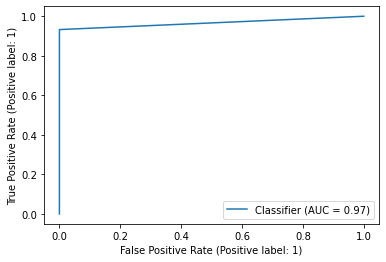

In [6]:
print_results(test_Y,preds)

In [7]:
# test_ci_ids = ["HM0004", "HM0005", "HS0001", "HS0002", "HS0009", "HS0010", "HS0012","HS0013"]
test2_ci_ids = ["HS0010","HM0005","HS0002", "HS0005"]

# test_hi_ids = ["HL0005", "HL0075", "HL0024", "HL0034", "HL0089"]
test2_hi_ids = ["HL0101", "HL0023", "HL0031", "HL0060", "HL0091", "HL0125", "HL0071", "HL0043", "HL0094", "HL0111"]


# test_ci_with_y = loads_npy_with_y("CI",train_ci_ids,1)
test2_ci_with_y = loads_npy_with_y("CI",test2_ci_ids,1)

# test_hi_with_y = loads_npy_with_y("HI",train_hi_ids,0
test2_hi_with_y = loads_npy_with_y("HI",test2_hi_ids,0)

test2_X_with_Y = np.concatenate([test2_ci_with_y, test2_hi_with_y], axis=0)
np.random.shuffle(test2_X_with_Y)

test2_X = test2_X_with_Y[:,:-1]
test2_Y = test2_X_with_Y[:, -1]

print(test2_X.shape)

(46412, 64000)


In [8]:
preds = model_predict(model, test2_X)

preds.shape:  (46000,)


accuracy:  0.9577391304347826
recall:  0.9975831399845321
precision:  0.8431933322438306
f1_score:  0.9139137366043751
specificity:  0.9461801660309626


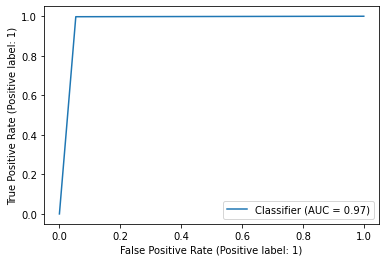

In [12]:
print_results(test2_Y,preds)